$\frac{\partial\rho}{\partial t} = -p\frac{\partial\rho}{\partial \varphi}-F(t,\varphi)\frac{\partial\rho}{\partial p}$ 


$H(\varphi,p) = \frac{p^2}{2}+\frac{(\varphi_{ext}-\varphi)^2}{2l_q}+(1-\cos\varphi)$ 


$F(t,\varphi) = -\frac{\partial H([\varphi,p],t)}{\partial\varphi}$

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("nbagg")

$\varphi_{ext} = \pi(\tanh(\frac{2\pi t}{\tau_{ext}}-\pi)+1))$,

$\tau_{ext}$ время "действия" функции 

Непонятно в чем "магия", но чем больше  шаг, тем меньше точность. Смотри "Анализ по сетке СМ"

In [20]:
#параметры сетки и объявление элементов
Tlen = 20
dt = 0.0001
nt = int(Tlen/dt)        # number of time steps
Lz = 3*np.pi       # coordinate region
Lx = 4.5*np.pi
dx = np.pi/16 #Lx/(nx)     # calculate space increment
dz = np.pi/16 #Lz/(nz)
nx = int(Lx/dx)        # number of grid points in x  
nz = int(Lz/dz)         # number of grid points in z
iplot = 10000

f  = np.linspace(-np.pi/2,Lx-np.pi/2, nx) # initialize space coordinates
p  = np.linspace(-Lz/2, Lz/2, nz) # initialize space coordinates
#t   = np.arange(1, nt+1)*dt  # initialize time axis

# initialization of pressure fields
# помни, что у нас nz строк (движение по p) и nx столбцов 
sp = np.zeros((nz, nx), dtype= float)
sd2px = np.zeros((nz, nx), dtype=float) # матрица для производной по f
sd2pz = np.zeros((nz, nx), dtype=float) # матрица для производной по p

# plotting parameters
wid, hight = 6, 4

In [21]:
print("dt = ", dt,"\n","dx = ", dx,"\n", "dz =", dz,"\n", "nt = ", nt,"\n","snaps =", nt/iplot,"\n","nx = ", nx,"\n",
      "nz = ",nz,"\n")

dt =  0.0001 
 dx =  0.19634954084936207 
 dz = 0.19634954084936207 
 nt =  200000 
 snaps = 20.0 
 nx =  72 
 nz =  48 



In [22]:
#пришло время временной зависимости
tau = 19
def fx(t):
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1)
lq = 3
def H(f,p,t):
    return p**2/2 + (fx(t)-f)**2/(2*lq) + (1 - np.cos(f))
# производную для силы определили вручную
def F(f,t):
    return (fx(t)-f)/lq - np.sin(f)#-np.gradient(H(f,0))
#F(f)

<IPython.core.display.Javascript object>


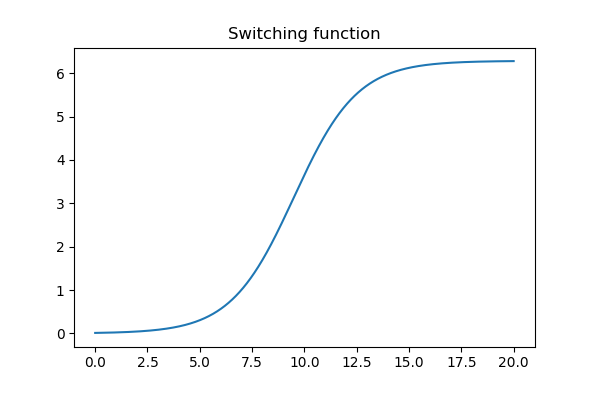

In [7]:
time=np.linspace(0,Tlen,nt)
fig = plt.figure(figsize=(wid,hight))
plt.plot(time,fx(time))
plt.title("Switching function")
plt.show()

<IPython.core.display.Javascript object>


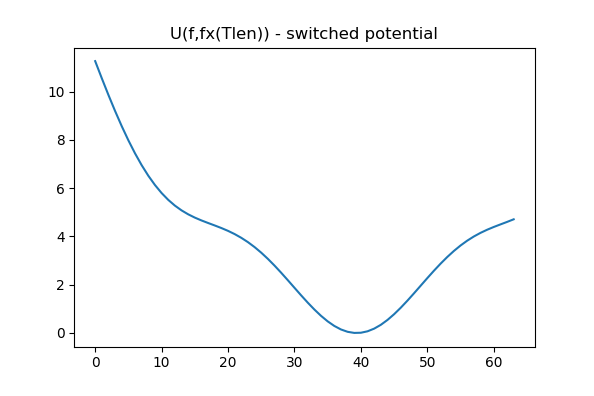

In [8]:
fig = plt.figure(figsize=(wid,hight))
plt.plot(H(f,0,Tlen))
plt.title("U(f,fx(Tlen)) - switched potential")
plt.show()
#H(f,0,Tlen)

<IPython.core.display.Javascript object>


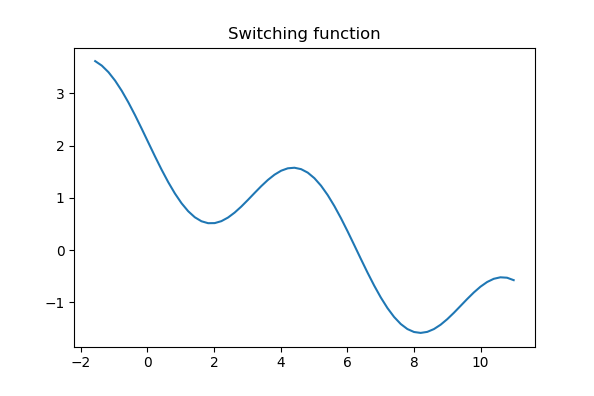

In [9]:
fig = plt.figure(figsize=(wid,hight))
plt.plot(f,F(f,Tlen))
plt.title("Switching function")
plt.show()

$\frac{\partial\rho}{\partial t} = -p\frac{\partial\rho}{\partial \varphi}-F(t,\varphi)\frac{\partial\rho}{\partial p}$ 

$\frac{\partial \rho}{\partial \varphi} = F^{-1}[ik_\varphi*F[\rho]]$

$\frac{\partial \rho}{\partial p} = F^{-1}[ik_p*F[\rho]]$

where $F^{-1}$ - innverse Fourier transform.

$\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1}-\rho^{n}}{dt}$

$\rho^{n+1} = \rho^{n} - dt(p*F^{-1}[ik_\varphi*F[\rho]]+Forse*F^{-1}[ik_p*F[\rho]])$

In [10]:
def fourier_derivative(f, dx):    
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)                                   # не до конца понимаю это место.
    k = np.arange(float(nx))                               # хотя сама делала что-то похожее с hstack
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)*ff
    df_num = np.real(np.fft.ifft(ff)) 
    return df_num       

In [23]:
# надо задать начатьное распределение
beta = 0.0276
#integ = lambda x: np.e**(-H(x,0)/beta)
Zf = integrate.quad(lambda x: np.e**(-H(x,0,0)/beta),-np.inf, np.inf)[0]
#Zf = integrate.quad(integ,-np.inf, np.inf)[0]
Zp = np.sqrt(2*np.pi*beta)               # статсуммы вроде как сходятся
def rho0(f, p):                          # функция работает как надо
    return (np.e**(-H(f,p,0)/beta))/(Zf*Zp)
beg = np.zeros((nz, nx), dtype= float) #матрица нулей для начального распределения
for i in range(nz):
    for j in range(nx):
        beg[i,j] =  rho0(p[i],f[j])

<IPython.core.display.Javascript object>


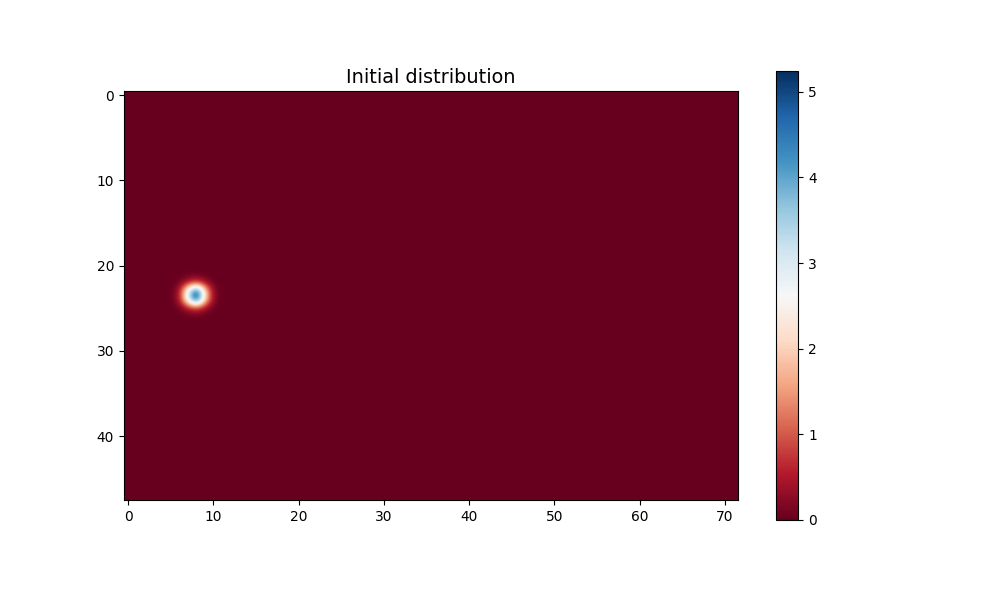

In [24]:
fig = plt.figure(figsize=(10,6))
plt.imshow(beg, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title('Initial distribution', size=14)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


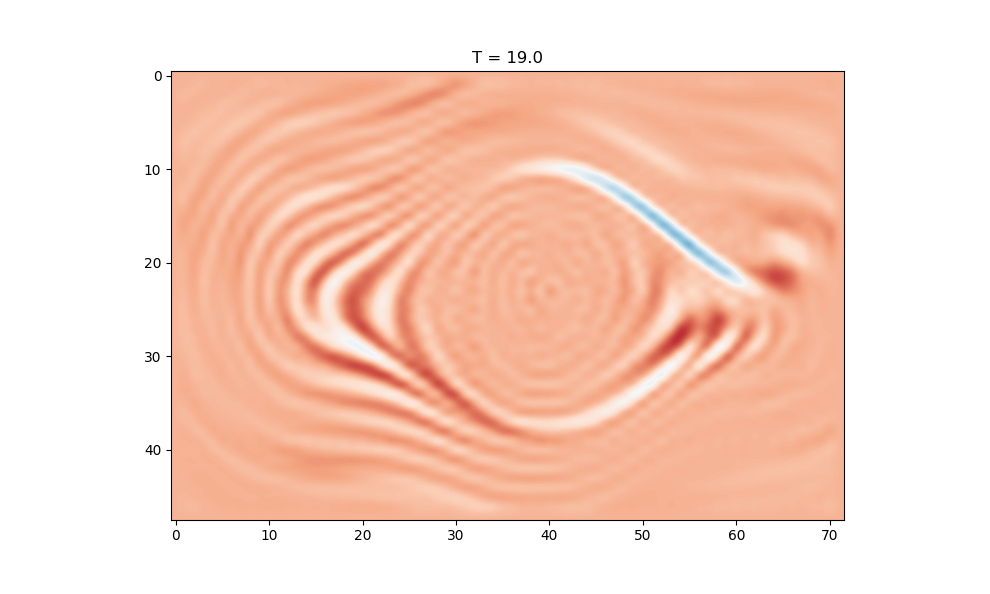

In [25]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title('Fourier Method', size=14)
#plt.colorbar()
plt.ion()   # set interective mode
plt.show()

In [26]:
sp = beg #в нулевой момент времнени плотность равна НУ

for it in range(nt):
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    # space derivative
    for j in np.arange(nx):                                          # производная по p     
        #sd2px[:,j] = p[j]*fourier_derivative(sp[:,j].T, dz) 
        sd2px[:,j] = F(f[j],it*dt)*fourier_derivative(sp[:,j], dz) # тут даже запись определяет, что движение по j (???)
    for i in np.arange(nz):                                          # производная по f    
        #sd2pz[i,:] = F(f,it*dt)[i]*fourier_derivative(sp[i,:], dx)
        sd2pz[i,:] = p[i]*fourier_derivative(sp[i,:], dx)
        
    # Time Extrapolation
    sp = sp - dt*(sd2px + sd2pz)    
    sp[0,:] = sp[:,0] = sp[int(nz-1),:] = sp[:,int(nx-1)] = 0 #нелевые граничные условия
   
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu) 
        plt.title("T = {}".format(it*dt))
        plt.gcf().canvas.draw()

In [240]:
# sp все еще по определеннию плотность веротности
print("интеграл по поверхности новой ф-ии =",np.sum(sp)*dx*dz)

интеграл по поверхности новой ф-ии = 0.880754214128164


In [241]:
# sp все еще по определеннию плотность веротности
print("интеграл по поверхности нач распр-я =",np.sum(beg)*dx*dz)

интеграл по поверхности нач распр-я = 0.9455820373542854
